## Time-series based analysis of Earthquake Risk Factors

### Part 6: Time-series analysis on original time-series using multi-variate time-series analysis.

Importing the required libraries:

In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import pickle
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## for machine learning

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking

### Importing the saved clean time-series earthquake data

In [2]:
file_path = "../datasets/" + "combined_eq_california" + "_timeseries" + ".csv"

df_eq = pd.read_csv(file_path)

df_eq = df_eq[["time", "mag", "sig", "longitude", "latitude", "depth"]]

df_eq["time"] = pd.to_datetime(df_eq["time"])
df_eq["timestamps"] = df_eq["time"]
df_eq.set_index('time', inplace=True)


df_eq

,mag,sig,longitude,latitude,depth,timestamps
time,,,,,,
1970-01-02 10:45:20.570,3.14,152,-119.695667,34.206000,6.000000,1970-01-02 10:45:20.570
1970-01-02 21:47:53.740,2.61,105,-117.733667,35.735167,1.650000,1970-01-02 21:47:53.740
1970-01-03 02:51:58.400,4.00,246,-122.088000,37.298000,6.274206,1970-01-03 02:51:58.400
1970-01-03 19:48:40.840,3.16,154,-116.830500,33.960500,6.000000,1970-01-03 19:48:40.840
1970-01-04 02:27:15.700,2.74,116,-116.843333,34.333500,6.000000,1970-01-04 02:27:15.700
...,...,...,...,...,...,...
2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.970000,2020-10-01 15:00:48.340
2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.110000,2020-10-01 15:10:23.760
2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.650000,2020-10-01 15:12:42.120


In [3]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313342 entries, 1970-01-02 10:45:20.570000 to 2020-10-01 15:28:09.630000
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   mag         313342 non-null  float64       
 1   sig         313342 non-null  int64         
 2   longitude   313342 non-null  float64       
 3   latitude    313342 non-null  float64       
 4   depth       313342 non-null  float64       
 5   timestamps  313342 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 16.7 MB


In [4]:
df_eq.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mag,313342.0,2.503171,0.510198,2.000,2.140000,2.35000,2.7000,7.300
sig,313342.0,101.852379,56.402848,62.000,70.000000,85.00000,112.0000,2910.000
longitude,313342.0,-118.583263,3.334398,-131.771,-121.236417,-118.09600,-116.3200,-107.001
latitude,313342.0,37.001109,4.004880,24.007,34.052000,36.19625,38.8195,50.000
depth,313342.0,6.274206,6.207409,-3.500,2.232000,5.38500,8.7770,257.000


### Checking the time_stamps:

Text(0, 0.5, 'Timestamp')

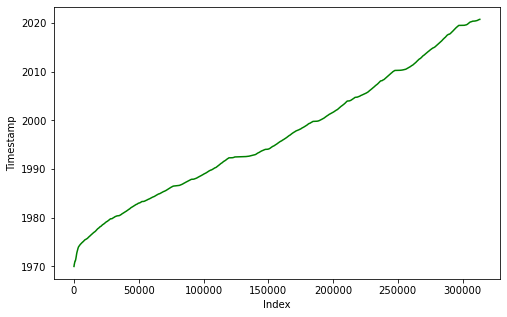

In [5]:
plt.figure(figsize = (8, 5))

plt.plot(df_eq.index, "g")
plt.xlabel('Index')
plt.ylabel('Timestamp')

In [6]:
df_eq.shape

(313342, 6)

## Important: need to drop repetitive rows (10 rows). There were some overlaps in original data.

In [7]:
df_eq[df_eq.duplicated('timestamps')]

,mag,sig,longitude,latitude,depth,timestamps
time,,,,,,
1983-07-26 19:03:28.580,2.44,92,-117.680000,35.030000,-0.861,1983-07-26 19:03:28.580
1999-10-26 22:16:20.490,3.15,153,-120.000000,37.000000,5.881,1999-10-26 22:16:20.490
2003-11-06 22:04:13.230,3.68,668,-121.668167,37.204666,-0.334,2003-11-06 22:04:13.230
2008-01-16 00:39:53.930,2.19,74,-111.222833,39.419833,-1.760,2008-01-16 00:39:53.930
2012-08-26 21:17:26.720,3.94,239,-115.607667,32.980167,8.924,2012-08-26 21:17:26.720
2013-09-13 12:56:00.720,3.70,211,-110.789300,44.752300,4.110,2013-09-13 12:56:00.720
2015-08-04 02:01:57.000,2.90,130,-113.768000,47.684000,11.500,2015-08-04 02:01:57.000
2016-02-06 00:33:04.420,2.80,121,-112.743200,37.146800,17.960,2016-02-06 00:33:04.420
2019-10-28 08:10:43.470,3.12,150,-122.778833,38.807000,0.970,2019-10-28 08:10:43.470


In [8]:
# Dropping rows
df_eq = df_eq.drop_duplicates(subset=['timestamps'])

df_eq["timestamps"].diff().describe()

count                       313331
mean     0 days 01:25:11.019876935
std      0 days 02:33:43.027017800
min         0 days 00:00:00.009000
25%         0 days 00:08:25.260000
50%         0 days 00:36:55.740000
75%         0 days 01:45:43.790000
max         8 days 04:01:06.380000
Name: timestamps, dtype: object

In [9]:
df_eq.head()

,mag,sig,longitude,latitude,depth,timestamps
time,,,,,,
1970-01-02 10:45:20.570,3.14,152,-119.695667,34.206000,6.000000,1970-01-02 10:45:20.570
1970-01-02 21:47:53.740,2.61,105,-117.733667,35.735167,1.650000,1970-01-02 21:47:53.740
1970-01-03 02:51:58.400,4.00,246,-122.088000,37.298000,6.274206,1970-01-03 02:51:58.400
1970-01-03 19:48:40.840,3.16,154,-116.830500,33.960500,6.000000,1970-01-03 19:48:40.840
1970-01-04 02:27:15.700,2.74,116,-116.843333,34.333500,6.000000,1970-01-04 02:27:15.700


## Feature engineering

In [10]:
# Number 1: Time intervals between consecutive earthquakes.
df_eq["time_diff"] = df_eq["timestamps"].diff()

df_eq["time_diff_float"] = df_eq["time_diff"].apply(lambda x: x.total_seconds())

#Number 2: the rolling of magnitudes from the last 10 earthquakes

df_eq["mag_roll_10"] = df_eq["mag"].rolling(window=10).mean()

df_eq.dropna(inplace = True)

df_eq.head(10)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
time,,,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.000,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.660,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189
1970-01-07 18:04:50.000,3.07,145,-120.980667,34.607000,6.000,1970-01-07 18:04:50.000,0 days 14:39:23.890000,52763.89,3.235
1970-01-08 02:16:41.350,2.75,116,-117.139833,34.307833,6.000,1970-01-08 02:16:41.350,0 days 08:11:51.350000,29511.35,3.110
1970-01-08 17:00:33.860,3.70,211,-121.565833,34.574333,6.000,1970-01-08 17:00:33.860,0 days 14:43:52.510000,53032.51,3.164
1970-01-09 05:08:10.650,2.44,92,-118.610167,35.397000,6.000,1970-01-09 05:08:10.650,0 days 12:07:36.790000,43656.79,3.134
1970-01-10 01:17:20.290,2.50,96,-118.215000,46.923667,1.486,1970-01-10 01:17:20.290,0 days 20:09:09.640000,72549.64,3.080
1970-01-10 02:47:03.430,3.03,141,-119.112000,34.435833,6.000,1970-01-10 02:47:03.430,0 days 01:29:43.140000,5383.14,2.991
1970-01-10 11:45:25.680,2.97,136,-116.341333,34.679167,6.880,1970-01-10 11:45:25.680,0 days 08:58:22.250000,32302.25,2.983


### Labeling the large earthquakes (M>6). This helps slicing the time-series for later specific purposes

In [11]:
## Large earthquakes labeling:
label = []
cnt = 0
for i, mag in enumerate(df_eq["mag"]):
    if (mag>6):
        cnt = cnt + 1
        label.append(int(cnt))
    else:
        label.append(0)

df_eq["large_eq_label"] = label

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
df_eq.head()

,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10,large_eq_label
time,,,,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263,0
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189,0
1970-01-07 18:04:50.000,3.07,145,-120.980667,34.607000,6.00,1970-01-07 18:04:50.000,0 days 14:39:23.890000,52763.89,3.235,0
1970-01-08 02:16:41.350,2.75,116,-117.139833,34.307833,6.00,1970-01-08 02:16:41.350,0 days 08:11:51.350000,29511.35,3.110,0
1970-01-08 17:00:33.860,3.70,211,-121.565833,34.574333,6.00,1970-01-08 17:00:33.860,0 days 14:43:52.510000,53032.51,3.164,0


In [13]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,313323,2.50313,0.510172,2,2.14,2.35,2.7,7.3
sig,313323,101.847,56.3927,62,70,85,112,2910
longitude,313323,-118.583,3.33437,-131.771,-121.236,-118.096,-116.32,-107.001
latitude,313323,37.0011,4.0049,24.007,34.052,36.1962,38.8195,50
depth,313323,6.27424,6.20748,-3.5,2.232,5.385,8.777,257
time_diff,313323,0 days 01:25:09.914685356,0 days 02:33:38.876407841,0 days 00:00:00.009000,0 days 00:08:25.235000,0 days 00:36:55.720000,0 days 01:45:43.478000,8 days 04:01:06.380000
time_diff_float,313323,5109.91,9218.88,0.009,505.235,2215.72,6343.48,705666
mag_roll_10,313323,2.50314,0.226073,2.043,2.354,2.46,2.597,4.826
large_eq_label,313323,0.0116653,0.815345,0,0,0,0,85


In [14]:
# df_eq["time_diff_float"] = np.datetime64(df_eq["time_diff"][0]).astype(float)
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313323 entries, 1970-01-07 01:14:49.890000 to 2020-10-01 15:28:09.630000
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   mag              313323 non-null  float64        
 1   sig              313323 non-null  int64          
 2   longitude        313323 non-null  float64        
 3   latitude         313323 non-null  float64        
 4   depth            313323 non-null  float64        
 5   timestamps       313323 non-null  datetime64[ns] 
 6   time_diff        313323 non-null  timedelta64[ns]
 7   time_diff_float  313323 non-null  float64        
 8   mag_roll_10      313323 non-null  float64        
 9   large_eq_label   313323 non-null  int64          
dtypes: datetime64[ns](1), float64(6), int64(2), timedelta64[ns](1)
memory usage: 26.3 MB


### Checking the entiretity of the time-series

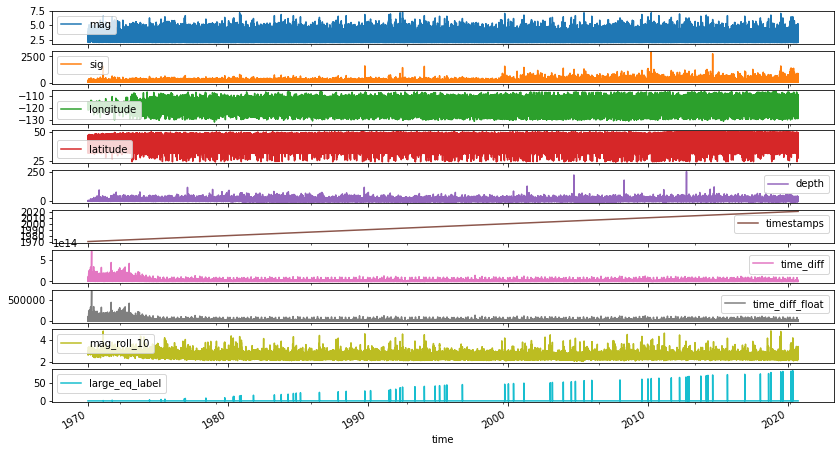

In [15]:
df_eq.plot(subplots=True,figsize=(14,8));

### Is there any collinearity between parameters:

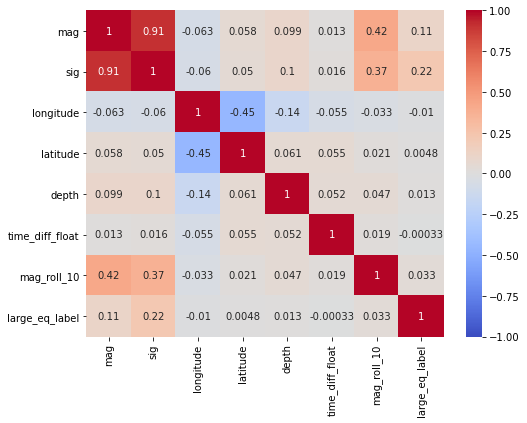

In [16]:
df_corr = df_eq.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr,
        vmin=-1,
        cmap='coolwarm',
        annot=True);
# plt.savefig("../plots/Loma_prieta_EDA_corr_plots.png")

### Figure discussion: 
---
Mag and sig are almost correlated, meaning that sig which was based on judgement and phsycial mag are corrleated. On the other hand, mag and sig coud happen on all depoths and longitude/latitudes.<br>
Longitude and latitude are negatively correlated meaning that the lineation going from NW-SE happening.

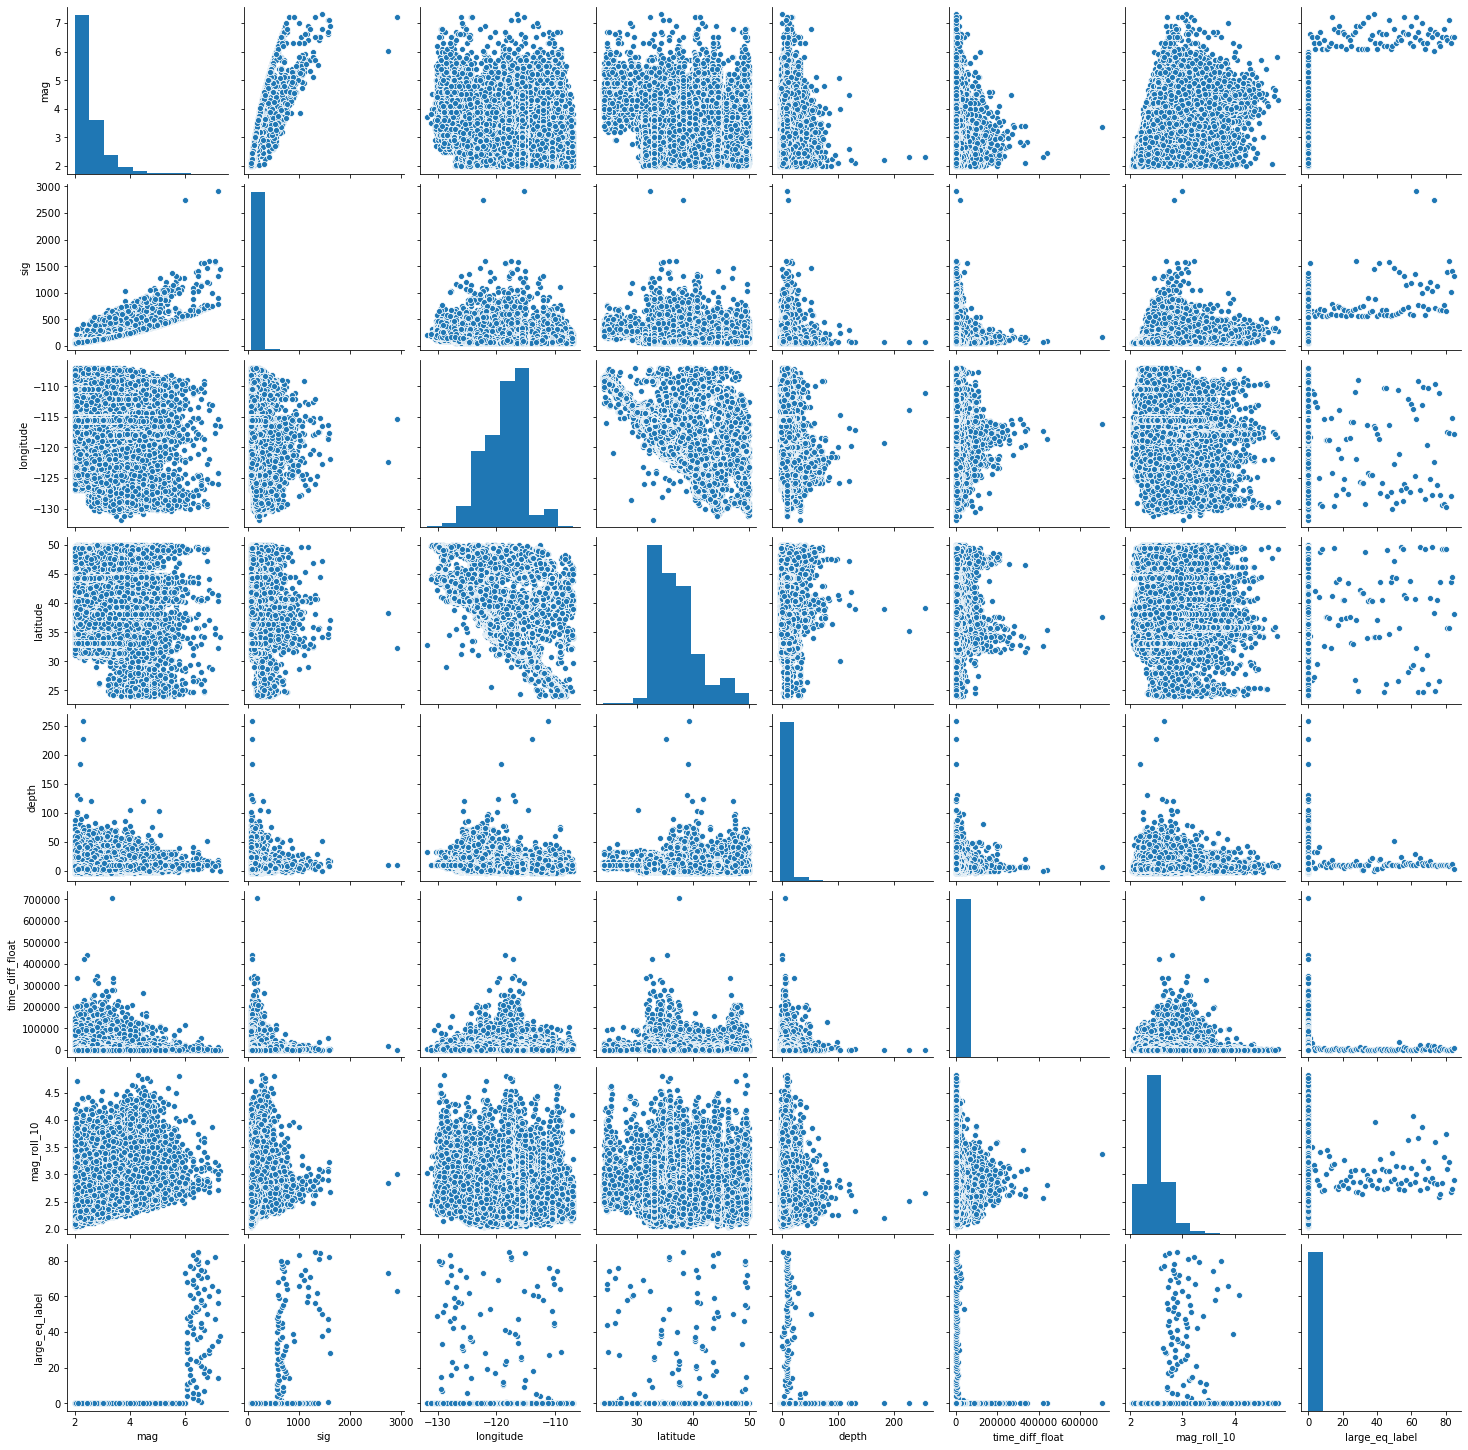

In [17]:
sns.pairplot(df_eq, hue=None);

### Figure discussion: 
---
The large earthquakes tend to occur in shallow depths.
Similar conclusions as the correlation maps.

Text(0, 0.5, 'Latitude')

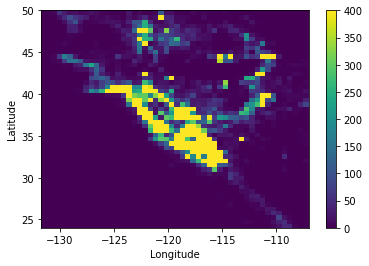

In [18]:
df_eq_plot = df_eq[df_eq["depth"]<50]

plt.hist2d(df_eq_plot['longitude'], df_eq_plot['latitude'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Depth (km)')

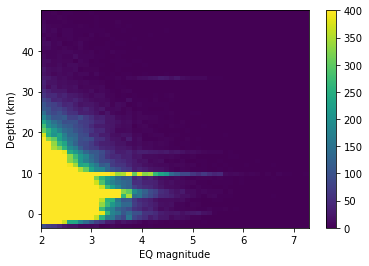

In [19]:
df_eq_plot = df_eq[df_eq["depth"]<50]

plt.hist2d(df_eq_plot['mag'], df_eq_plot['depth'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('EQ magnitude')
plt.ylabel('Depth (km)')

### Figure discussion: 
---
The plots corroborate the mentioned points. Top: There is strong lineation NW-SE between longitude-latitude. Bottom: At the depth of ~10 km, there seems to be clustering of major earthquakes

### distribution of time steps between sequential data:

In [20]:
df_eq["time_diff_float"].describe()

count    313323.000000
mean       5109.914685
std        9218.876408
min           0.009000
25%         505.235000
50%        2215.720000
75%        6343.478000
max      705666.380000
Name: time_diff_float, dtype: float64

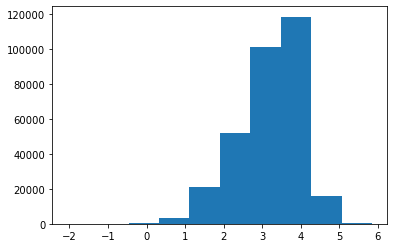

In [21]:
plt.hist(np.log10(df_eq["time_diff_float"]));

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


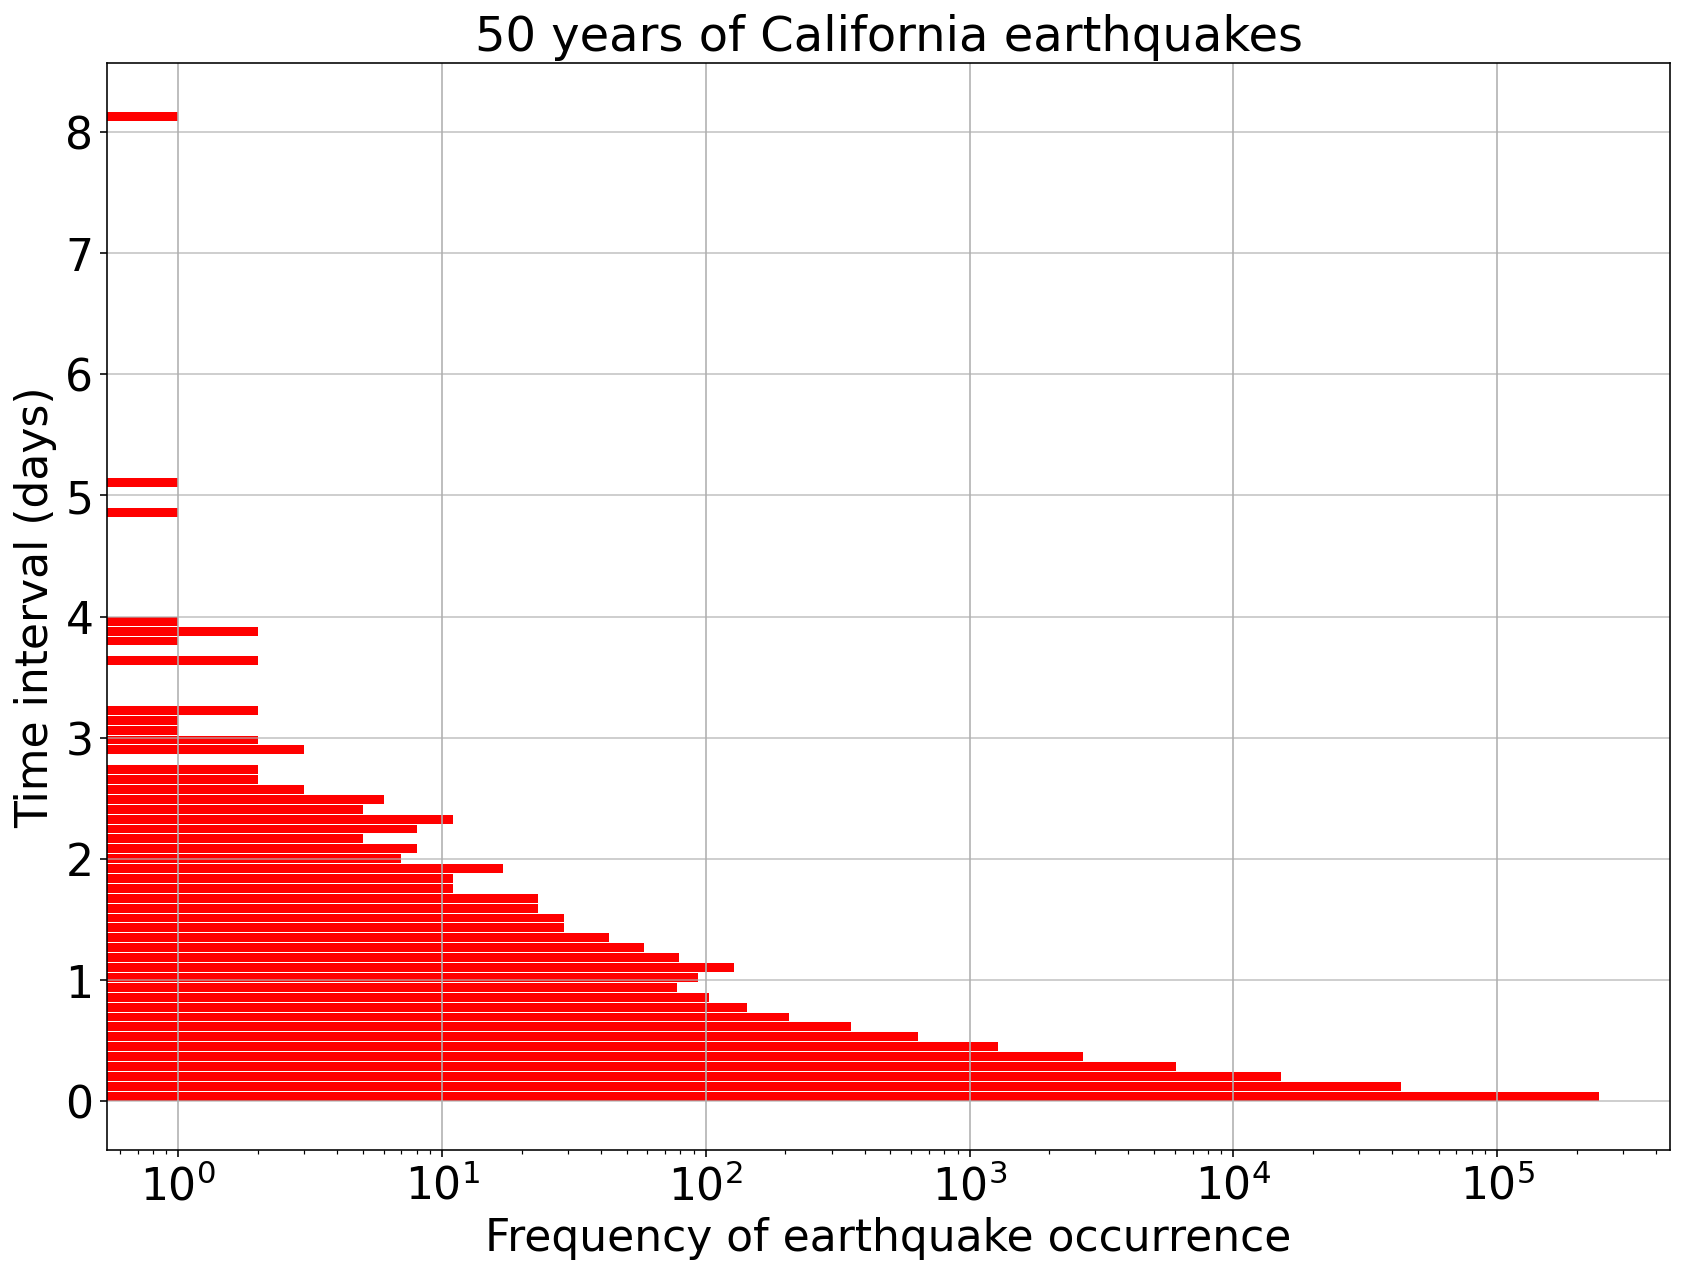

In [28]:
df_eq["time_days"] = (np.array(df_eq["time_diff_float"])/86_400)


%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (14, 10));




df_eq["time_days"].plot.hist(grid=True, bins=100, rwidth=0.9,orientation="horizontal",
                   color='red')

plt.title('50 years of California earthquakes',fontsize = 24)
plt.ylabel('Time interval (days)',fontsize = 22)
plt.xlabel('Frequency of earthquake occurrence',fontsize = 22)

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

# plt.ylim(0, 6)
plt.grid(axis='y', alpha=0.75)

plt.xscale('log')


plt.savefig('../plots/Medium_fig_2.png')

#### Dropping the unnecessary columns for time-series modeling:

#### Source: https://www.youtube.com/watch?v=xaIA83x5Icg

Split the data into train/test with 10% of data as test dataset

In [28]:
df_eq_model = df_eq.drop(columns = ["time_diff", "large_eq_label","timestamps"])

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(281990, 7) (31333, 7)


In [29]:
train.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,10599.22,3.263
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,7836.22,3.189


In [30]:
test.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
2015-11-17 08:03:05.160,2.28,80,-121.991833,40.287000,9.76,21657.79,2.350
2015-11-17 09:33:00.880,2.79,120,-122.846833,38.825667,1.82,5395.72,2.415


Scaling the data:

In [31]:

f_columns = ["longitude", "latitude", "depth", "time_diff_float", "mag_roll_10"]

f_transformer = RobustScaler()
mag_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
mag_transformer = mag_transformer.fit(train[["mag"]])

In [32]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [33]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["mag"] = mag_transformer.transform(train[["mag"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["mag"] = mag_transformer.transform(test[["mag"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### Preparing the data for LSTM

In [34]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [52]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["mag"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["mag"], time_steps= TIME_STEPS)

In [53]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(281930, 60, 7) (281930,)
(31273, 60, 7) (31273,)


In [54]:
X_train[0][0]

array([ 1.71428571e+00,  1.69000000e+02,  5.07240561e-01, -9.39736033e-01,
        1.12544691e-01,  1.43384977e+00,  3.29508197e+00])

## Model Architecture

In [58]:

model = keras.Sequential()
# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [59]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [60]:
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/10
5903/5903 [==============================] - 136s 23ms/step - loss: 0.8081 - val_loss: 0.8447
Epoch 2/10
5903/5903 [==============================] - 143s 24ms/step - loss: 0.8002 - val_loss: 0.8325
Epoch 3/10
5903/5903 [==============================] - 139s 24ms/step - loss: 0.7893 - val_loss: 0.8128
Epoch 4/10
5903/5903 [==============================] - 145s 25ms/step - loss: 0.7817 - val_loss: 0.8092
Epoch 5/10
5903/5903 [==============================] - 142s 24ms/step - loss: 0.7794 - val_loss: 0.8044
Epoch 6/10
5903/5903 [==============================] - 143s 24ms/step - loss: 0.7775 - val_loss: 0.8035
Epoch 7/10
5903/5903 [==============================] - 139s 24ms/step - loss: 0.7765 - val_loss: 0.8049
Epoch 8/10
5903/5903 [==============================] - 142s 24ms/step - loss: 0.7766 - val_loss: 0.8005
Epoch 9/10
5903/5903 [==============================] - 139s 24ms/step - loss: 0.7743 - val_loss: 0.8014
Epoch 10/10
5903/5903 [==============================] 

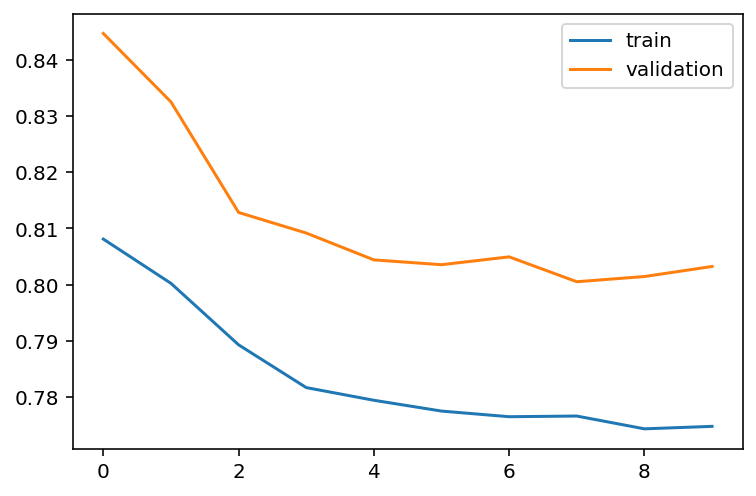

In [61]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


### Still, overfit! needs work

In [62]:
y_pred = model.predict(X_test)

In [63]:
y_train_inv = mag_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = mag_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = mag_transformer.inverse_transform(y_pred)





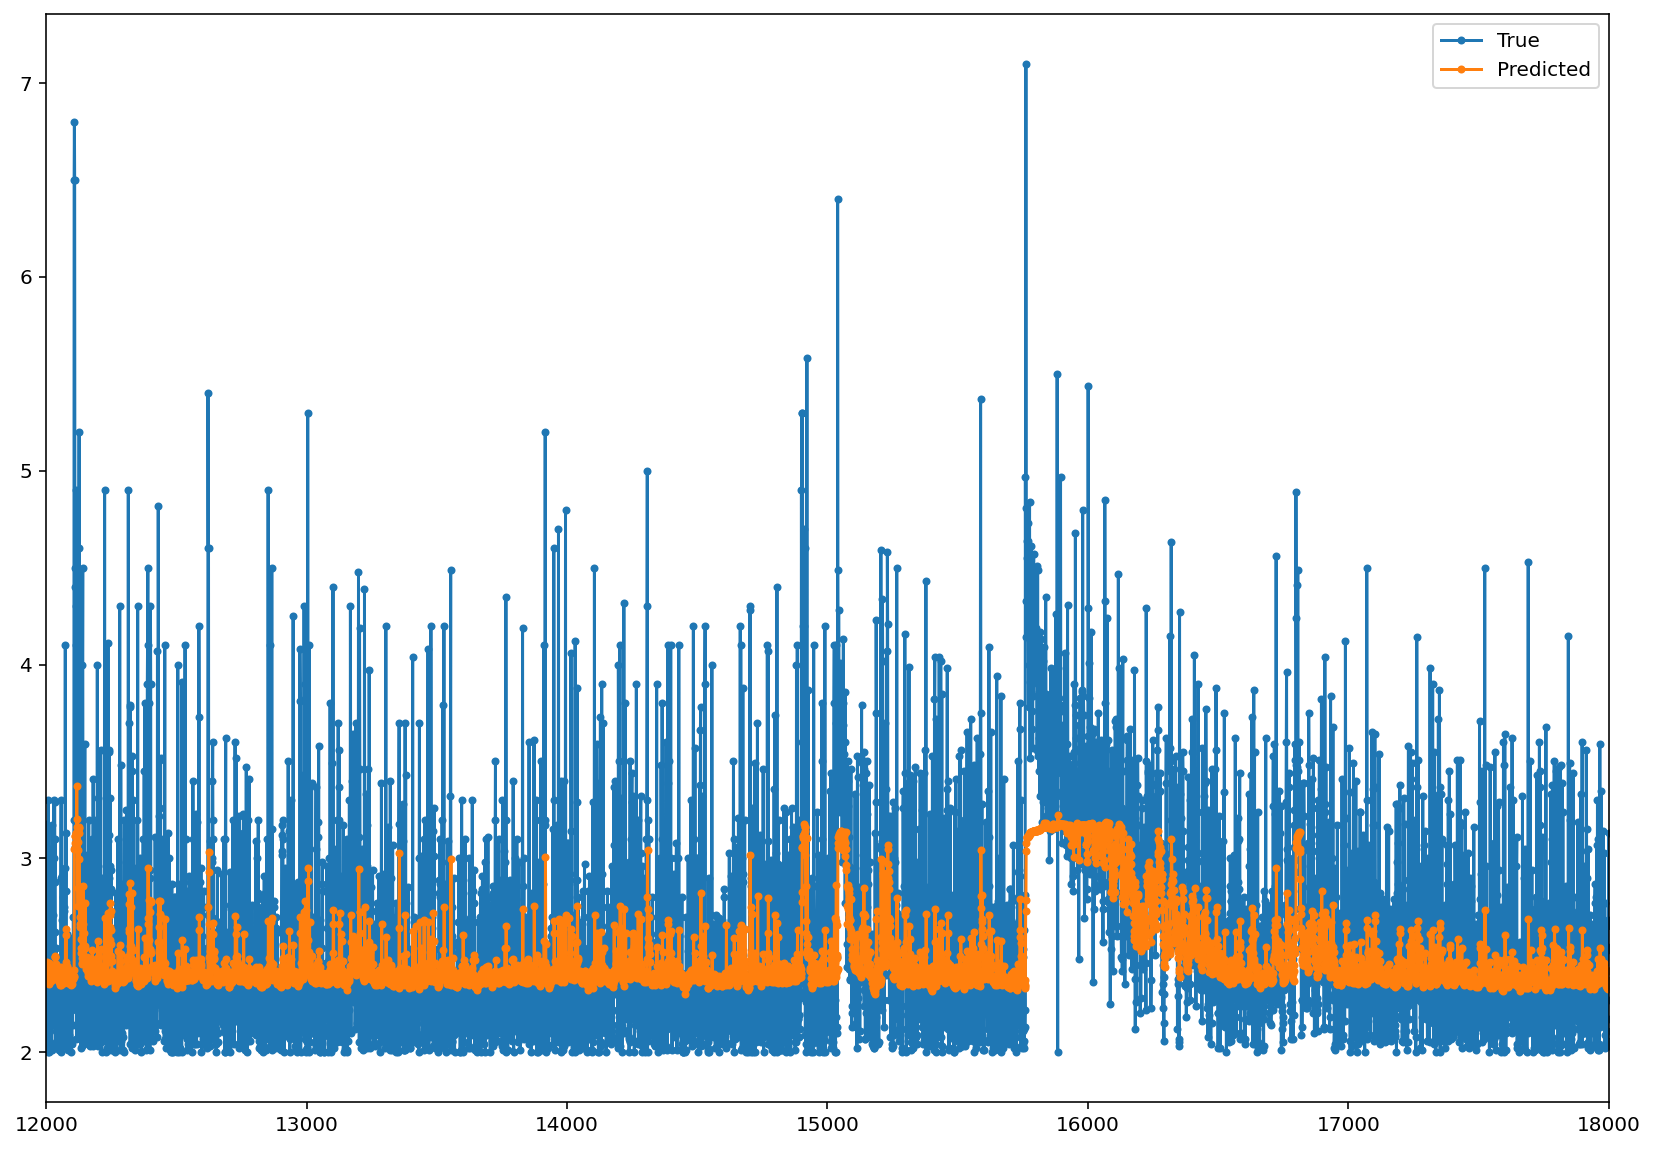

In [66]:
plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")
plt.xlim(12_000, 18_000)
plt.legend()

### Figure: Although the model slighly underpredicts the amplitude of magnitudes globally, still it can capture the main shock events (e.g., around x-values of 12,000, 15,000 and 16,000 in the above plot which were all earthquakes with magnitude > 6), which seems promising for future efforts.

# Can I predict the time_difference as label ?

In [143]:
df_eq_model = df_eq.drop(columns = ["time_diff", "large_eq_label","timestamps"])

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(281990, 7) (31333, 7)


In [144]:
train.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,10599.22,3.263
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,7836.22,3.189


In [145]:
test.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
2015-11-17 08:03:05.160,2.28,80,-121.991833,40.287000,9.76,21657.79,2.350
2015-11-17 09:33:00.880,2.79,120,-122.846833,38.825667,1.82,5395.72,2.415


In [149]:

f_columns = ["longitude", "latitude", "depth", "mag", "mag_roll_10"]

f_transformer = RobustScaler()
time_diff_float_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
time_diff_float_transformer = time_diff_float_transformer.fit(train[["time_diff_float"]])

In [150]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [151]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["time_diff_float"] = time_diff_float_transformer.transform(train[["time_diff_float"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["time_diff_float"] = time_diff_float_transformer.transform(test[["time_diff_float"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### Preparing the data for LSTM

In [152]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [153]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["time_diff_float"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["time_diff_float"], time_steps= TIME_STEPS)

In [154]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(281930, 60, 7) (281930,)
(31273, 60, 7) (31273,)


In [155]:
X_train[0][0]

array([ 1.71428571e+00,  1.69000000e+02,  5.07240561e-01, -9.39736033e-01,
        1.12544691e-01,  1.43384977e+00,  3.29508197e+00])

## Model Architecture

In [156]:

model = keras.Sequential()
# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [157]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [158]:
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/10
5903/5903 [==============================] - 126s 21ms/step - loss: 2.5627 - val_loss: 1.9164
Epoch 2/10
5903/5903 [==============================] - 118s 20ms/step - loss: 2.4698 - val_loss: 1.8522
Epoch 3/10
5903/5903 [==============================] - 118s 20ms/step - loss: 2.4210 - val_loss: 1.8528
Epoch 4/10
5903/5903 [==============================] - 118s 20ms/step - loss: 2.3865 - val_loss: 1.7853
Epoch 5/10
5903/5903 [==============================] - 117s 20ms/step - loss: 2.3323 - val_loss: 1.7015
Epoch 6/10
5903/5903 [==============================] - 118s 20ms/step - loss: 2.3277 - val_loss: 1.6831
Epoch 7/10
5903/5903 [==============================] - 117s 20ms/step - loss: 2.3085 - val_loss: 1.6758
Epoch 8/10
5903/5903 [==============================] - 117s 20ms/step - loss: 2.3130 - val_loss: 1.6420
Epoch 9/10
5903/5903 [==============================] - 117s 20ms/step - loss: 2.2860 - val_loss: 1.6001
Epoch 10/10
5903/5903 [==============================] 

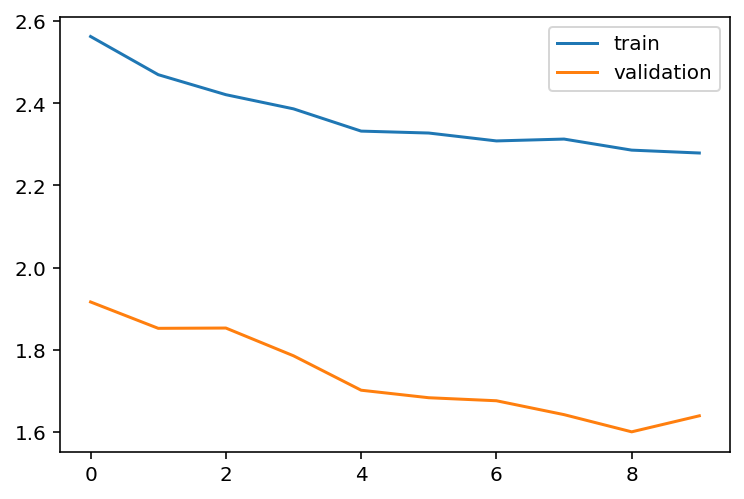

In [159]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


In [162]:
y_pred = model.predict(X_test)

In [163]:
y_train_inv = time_diff_float_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = time_diff_float_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = time_diff_float_transformer.inverse_transform(y_pred)





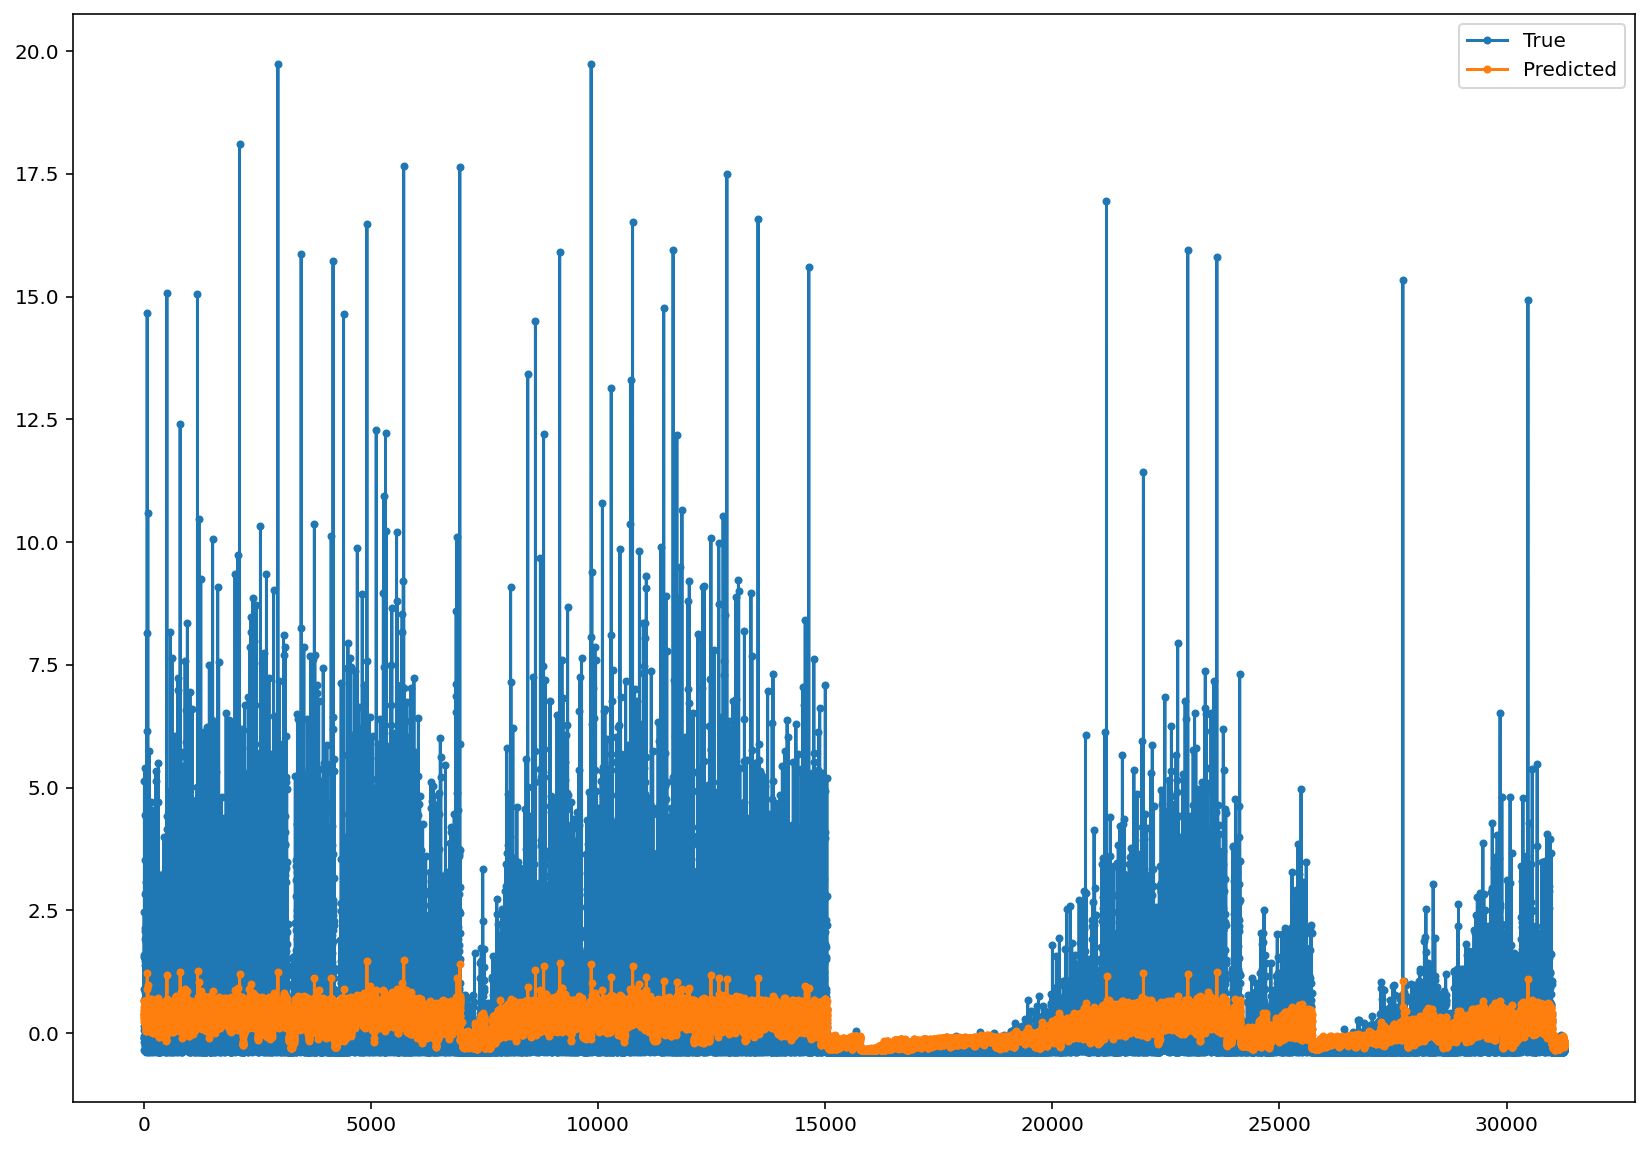

In [164]:
plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")

plt.legend()

### Answer to whether I can predict the time interval between earthquake sequences: Maybe!

## Time-intervals in original dataframe were irregular, what if I resample the data for every one hour?

In [271]:
Resamp_style = "1H"

df_eq_resampled = pd.DataFrame()
df_eq_resampled["mag"] = df_eq["mag"].resample(Resamp_style).max()
df_eq_resampled["sig"] = df_eq["sig"].resample(Resamp_style).max()
df_eq_resampled["longitude"] = df_eq["longitude"].resample(Resamp_style).mean()
df_eq_resampled["latitude"] = df_eq["latitude"].resample(Resamp_style).mean()
df_eq_resampled["depth"] = df_eq["depth"].resample(Resamp_style).mean()
df_eq_resampled["time_diff_float"] = df_eq["time_diff_float"].resample(Resamp_style).mean()
df_eq_resampled["mag_roll_10"] = df_eq["mag_roll_10"].resample(Resamp_style).max()

## Filling NA with -1
df_eq_resampled.fillna(-1, inplace=True)

df_eq_resampled.head(5)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:00:00,3.31,169.0,-115.817667,31.591833,6.00,10599.22,3.263
1970-01-07 02:00:00,-1.00,-1.0,-1.000000,-1.000000,-1.00,-1.00,-1.000
1970-01-07 03:00:00,2.40,89.0,-117.651833,35.817500,5.66,7836.22,3.189
1970-01-07 04:00:00,-1.00,-1.0,-1.000000,-1.000000,-1.00,-1.00,-1.000
1970-01-07 05:00:00,-1.00,-1.0,-1.000000,-1.000000,-1.00,-1.00,-1.000


In [272]:
df_eq.head(2)

,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10,large_eq_label
time,,,,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263,0
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189,0


In [273]:
df_eq_resampled.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,444735.0,0.459118,1.801252,-1.000,-1.000,-1.0,2.310000,7.300
sig,444735.0,44.383273,69.277635,-1.000,-1.000,-1.0,82.000000,2910.000
longitude,444735.0,-48.821521,57.899995,-130.872,-117.687,-1.0,-1.000000,-1.000
latitude,444735.0,14.552453,18.980415,-1.000,-1.000,-1.0,35.772875,50.000
depth,444735.0,2.068305,5.352684,-3.500,-1.000,-1.0,4.473417,132.093
time_diff_float,444735.0,2976.664919,7625.362196,-1.000,-1.000,-1.0,3379.650000,705666.380
mag_roll_10,444735.0,0.420199,1.723668,-1.000,-1.000,-1.0,2.415000,4.826


In [274]:
df_eq_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 444735 entries, 1970-01-07 01:00:00 to 2020-10-01 15:00:00
Freq: H
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   mag              444735 non-null  float64
 1   sig              444735 non-null  float64
 2   longitude        444735 non-null  float64
 3   latitude         444735 non-null  float64
 4   depth            444735 non-null  float64
 5   time_diff_float  444735 non-null  float64
 6   mag_roll_10      444735 non-null  float64
dtypes: float64(7)
memory usage: 27.1 MB


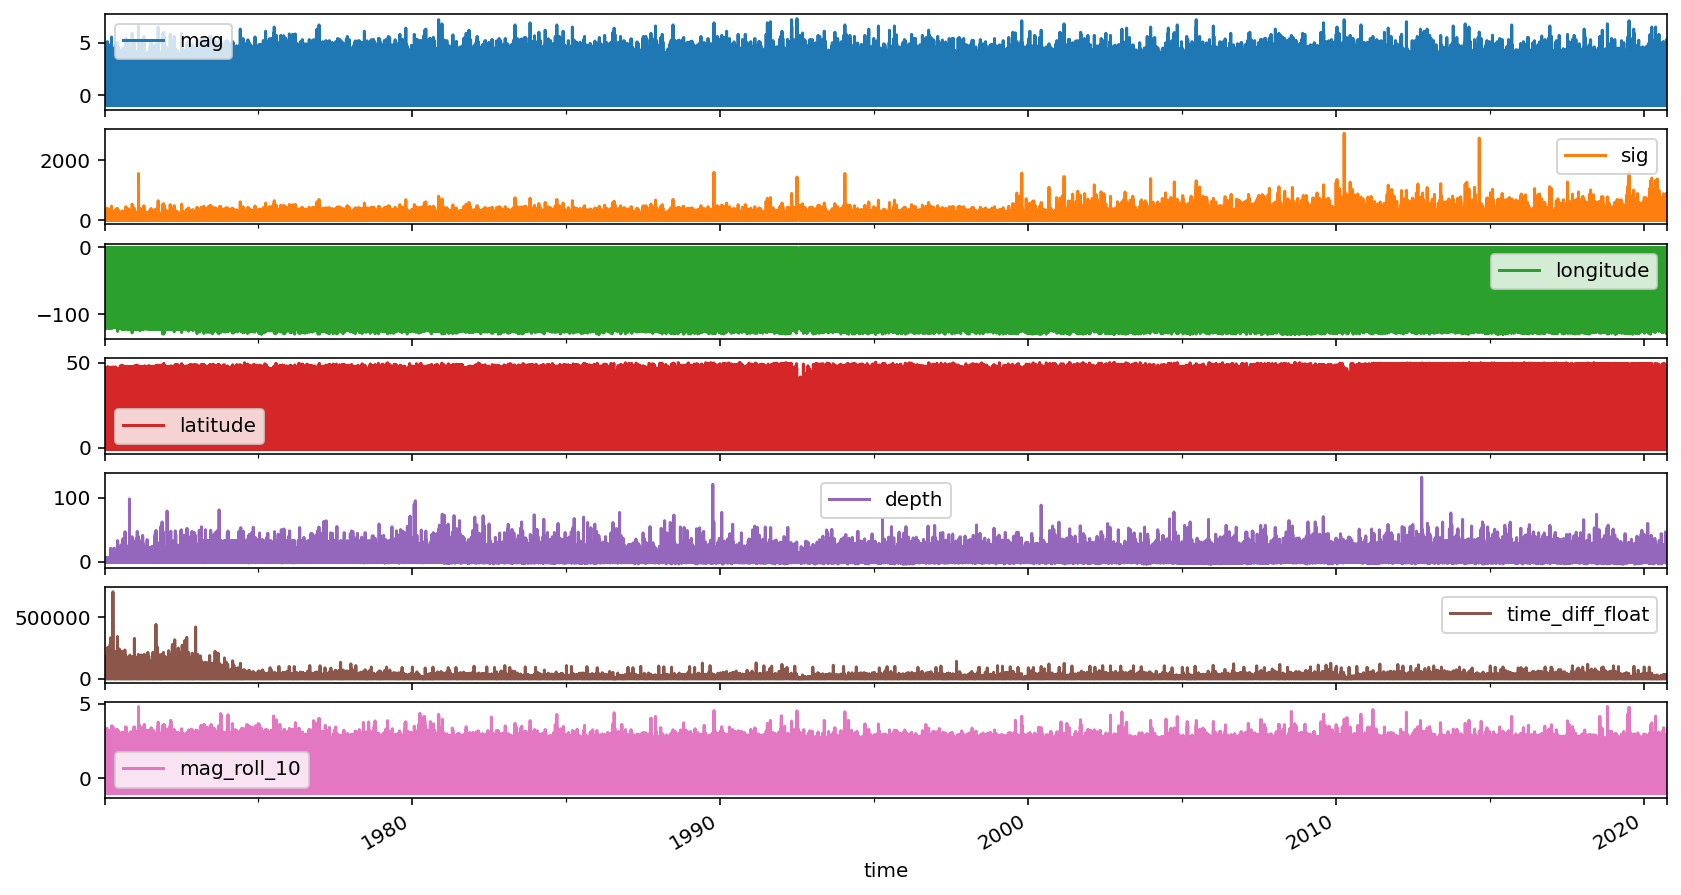

In [275]:
df_eq_resampled.plot(subplots=True,figsize=(14,8));

In [276]:
df_eq_model = df_eq_resampled.copy()


train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(400261, 7) (44474, 7)


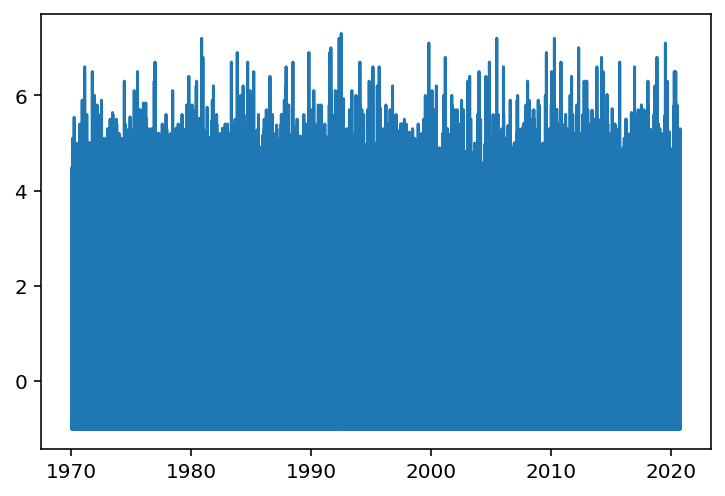

In [277]:
plt.plot(df_eq_model["mag"])

In [278]:
train.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:00:00,3.31,169.0,-115.817667,31.591833,6.0,10599.22,3.263
1970-01-07 02:00:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000


In [279]:
test.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
2015-09-05 14:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-09-05 15:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [280]:

f_columns = ["longitude", "latitude", "depth", "time_diff_float", "mag_roll_10"]

f_transformer = RobustScaler()
mag_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
mag_transformer = mag_transformer.fit(train[["mag"]])

In [281]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [282]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["mag"] = mag_transformer.transform(train[["mag"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["mag"] = mag_transformer.transform(test[["mag"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Preparing the data for LSTM

In [283]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [284]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["mag"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["mag"], time_steps= TIME_STEPS)

In [285]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(400201, 60, 7) (400201,)
(44414, 60, 7) (44414,)


In [286]:
X_train[0][0]

array([  1.29819277, 169.        ,  -0.98355006,   0.88862179,
         1.2959763 ,   3.13127294,   1.24795082])

## Model Architecture

In [287]:

model = keras.Sequential()
# Adding mask layer for NaN values
model.add(Masking(mask_value=-1.0,
                                  input_shape=(X_train.shape[1], X_train.shape[2])
                              )
         )
# Adding bi-directional layer


model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [288]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [289]:
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.2, 
    shuffle = False # As it is time-series
)

Epoch 1/10
10005/10005 [==============================] - 294s 29ms/step - loss: 0.2702 - val_loss: 0.2802
Epoch 2/10
10005/10005 [==============================] - 299s 30ms/step - loss: 0.2659 - val_loss: 0.2781
Epoch 3/10
10005/10005 [==============================] - 300s 30ms/step - loss: 0.2646 - val_loss: 0.2769
Epoch 4/10
10005/10005 [==============================] - 302s 30ms/step - loss: 0.2643 - val_loss: 0.2762
Epoch 5/10
10005/10005 [==============================] - 314s 31ms/step - loss: 0.2641 - val_loss: 0.2777
Epoch 6/10
10005/10005 [==============================] - 318s 32ms/step - loss: 0.2637 - val_loss: 0.2757
Epoch 7/10
10005/10005 [==============================] - 313s 31ms/step - loss: 0.2633 - val_loss: 0.2758
Epoch 8/10
10005/10005 [==============================] - 303s 30ms/step - loss: 0.2631 - val_loss: 0.2757
Epoch 9/10
10005/10005 [==============================] - 310s 31ms/step - loss: 0.2630 - val_loss: 0.2760
Epoch 10/10
10005/10005 [============

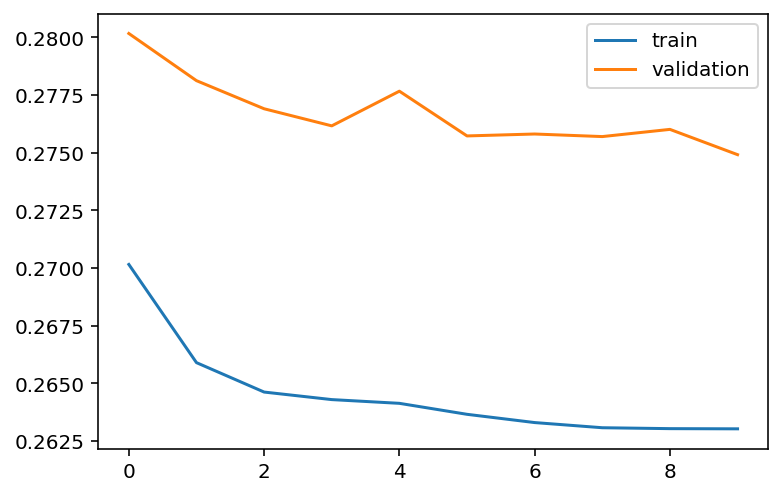

In [290]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


In [291]:
y_pred = model.predict(X_test)

In [292]:
y_train_inv = mag_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = mag_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = mag_transformer.inverse_transform(y_pred)





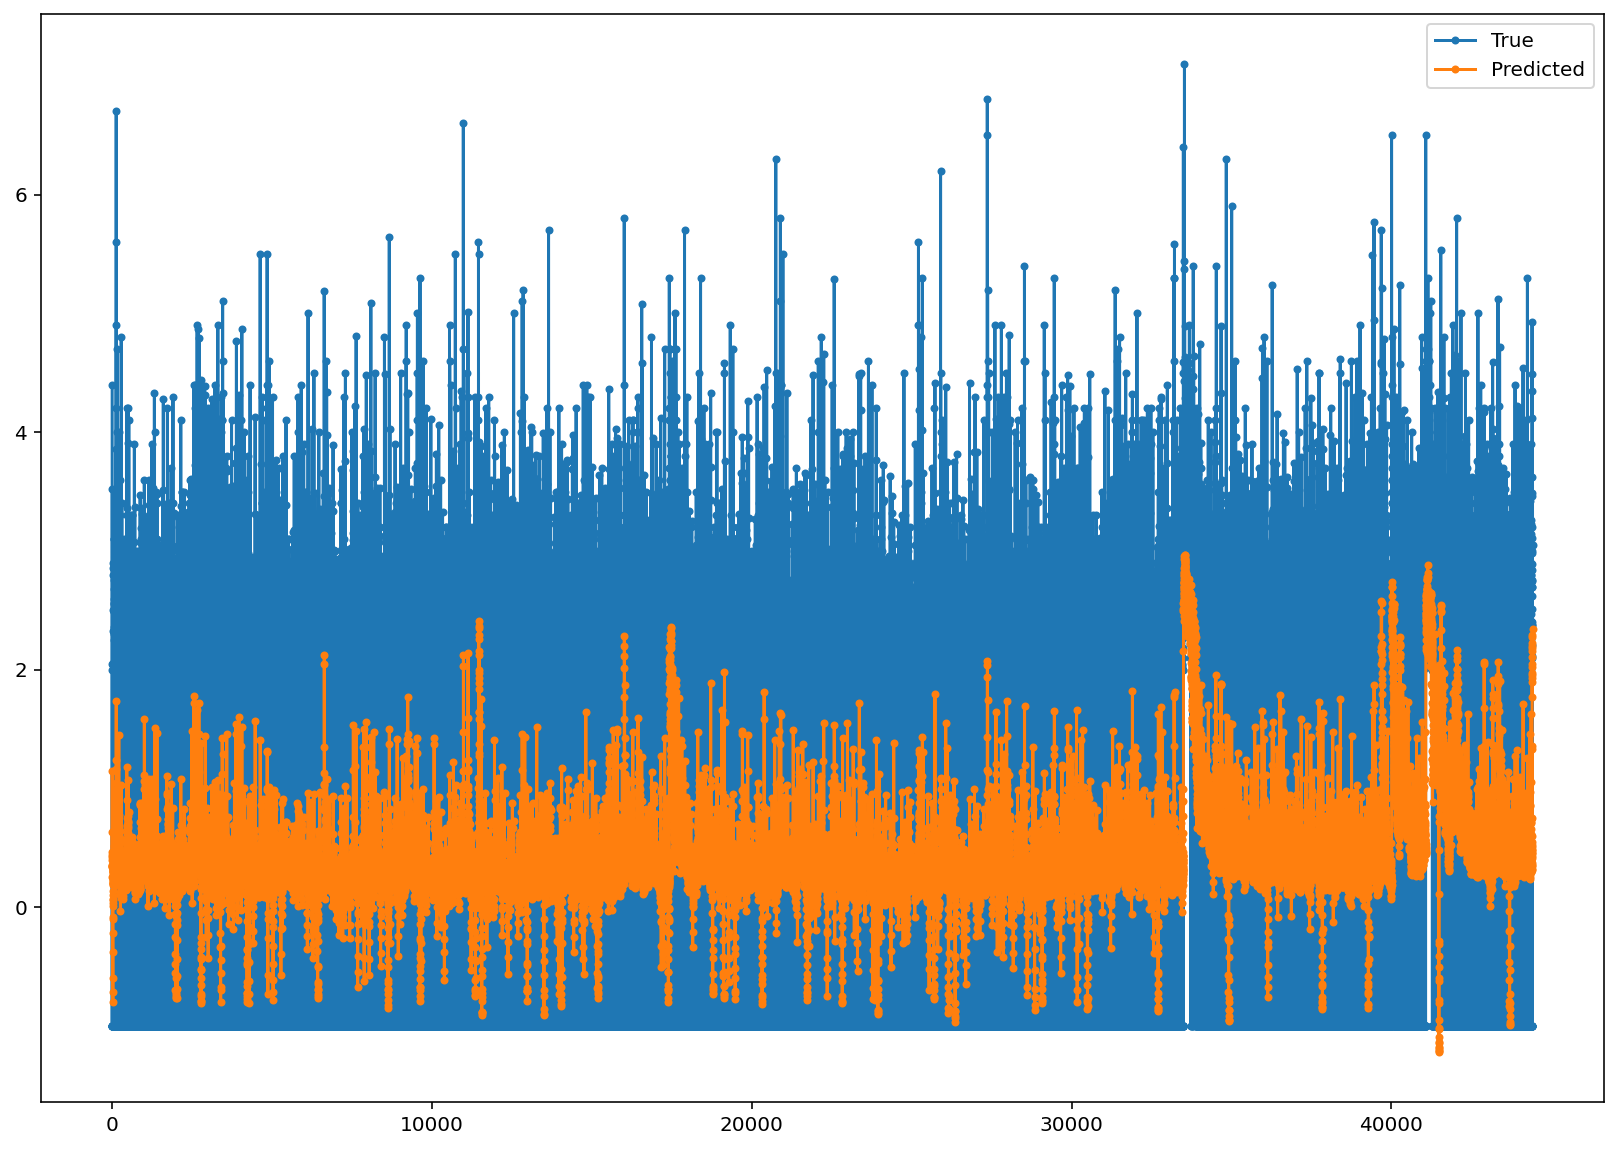

In [293]:
plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")

plt.legend()

### Maybe a bit better, as the model score is better and still the earthquake peaks are predicted

## Resampling the data now for every 5 minutes:

In [295]:
Resamp_style = "5T"

df_eq_resampled = pd.DataFrame()
df_eq_resampled["mag"] = df_eq["mag"].resample(Resamp_style).max()
df_eq_resampled["sig"] = df_eq["sig"].resample(Resamp_style).max()
df_eq_resampled["longitude"] = df_eq["longitude"].resample(Resamp_style).mean()
df_eq_resampled["latitude"] = df_eq["latitude"].resample(Resamp_style).mean()
df_eq_resampled["depth"] = df_eq["depth"].resample(Resamp_style).mean()
df_eq_resampled["time_diff_float"] = df_eq["time_diff_float"].resample(Resamp_style).mean()
df_eq_resampled["mag_roll_10"] = df_eq["mag_roll_10"].resample(Resamp_style).max()

## Filling NA with -1
df_eq_resampled.fillna(-1, inplace=True)

df_eq_resampled.head(5)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:10:00,3.31,169.0,-115.817667,31.591833,6.0,10599.22,3.263
1970-01-07 01:15:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000
1970-01-07 01:20:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000
1970-01-07 01:25:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000
1970-01-07 01:30:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000


In [296]:
df_eq.head(2)

,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10,large_eq_label
time,,,,,,,,,,
1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263,0
1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189,0


In [297]:
df_eq_resampled.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,5336812.0,-0.817206,0.789397,-1.000,-1.0,-1.0,-1.0,7.300
sig,5336812.0,4.412558,26.651687,-1.000,-1.0,-1.0,-1.0,2910.000
longitude,5336812.0,-7.118786,26.137082,-131.771,-1.0,-1.0,-1.0,-1.000
latitude,5336812.0,0.983020,8.517297,-1.000,-1.0,-1.0,-1.0,50.000
depth,5336812.0,-0.617350,2.167996,-3.500,-1.0,-1.0,-1.0,257.000
time_diff_float,5336812.0,291.824975,2507.420386,-1.000,-1.0,-1.0,-1.0,705666.380
mag_roll_10,5336812.0,-0.818232,0.777665,-1.000,-1.0,-1.0,-1.0,4.826


In [298]:
df_eq_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5336812 entries, 1970-01-07 01:10:00 to 2020-10-01 15:25:00
Freq: 5T
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   mag              float64
 1   sig              float64
 2   longitude        float64
 3   latitude         float64
 4   depth            float64
 5   time_diff_float  float64
 6   mag_roll_10      float64
dtypes: float64(7)
memory usage: 325.7 MB


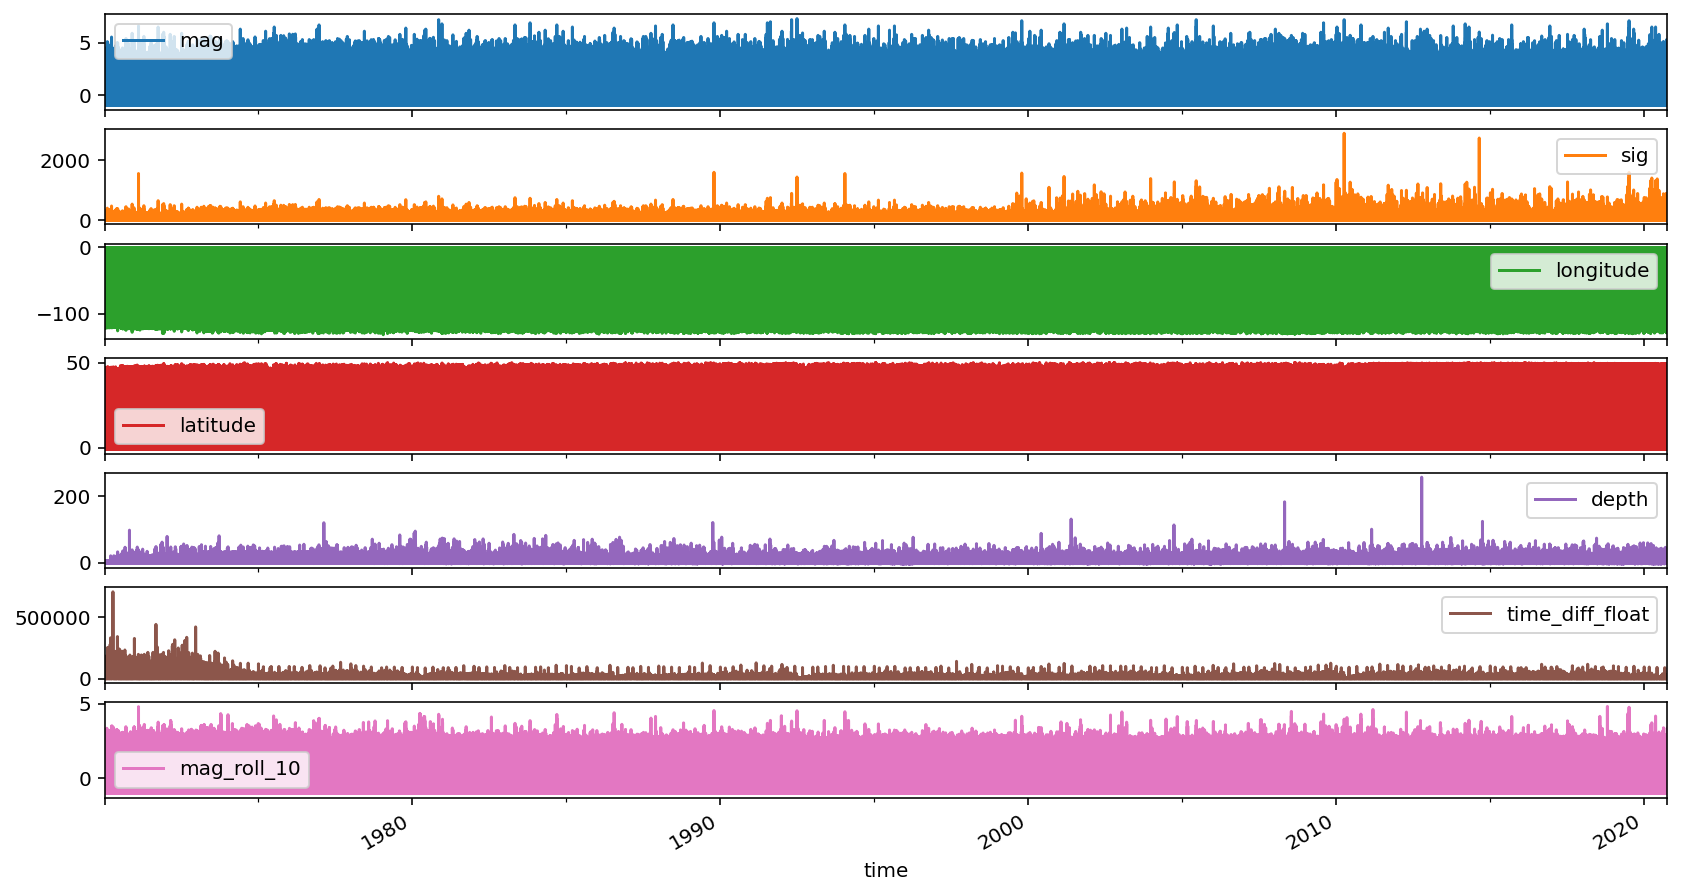

In [299]:
df_eq_resampled.plot(subplots=True,figsize=(14,8));

In [300]:
df_eq_model = df_eq_resampled.copy()


train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(4803130, 7) (533682, 7)


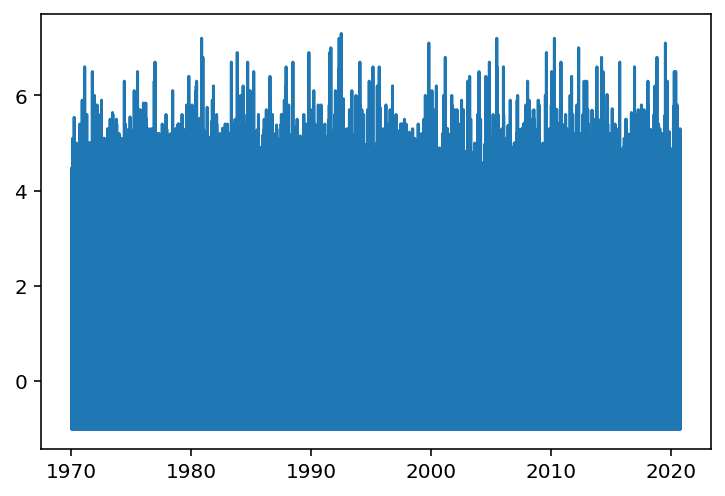

In [301]:
plt.plot(df_eq_model["mag"])

In [302]:
train.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
1970-01-07 01:10:00,3.31,169.0,-115.817667,31.591833,6.0,10599.22,3.263
1970-01-07 01:15:00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.00,-1.000


In [303]:
test.head(2)

,mag,sig,longitude,latitude,depth,time_diff_float,mag_roll_10
time,,,,,,,
2015-09-05 14:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-09-05 14:05:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [304]:

f_columns = ["longitude", "latitude", "depth", "time_diff_float", "mag_roll_10"]

f_transformer = RobustScaler()
mag_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
mag_transformer = mag_transformer.fit(train[["mag"]])

In [305]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [306]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["mag"] = mag_transformer.transform(train[["mag"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["mag"] = mag_transformer.transform(test[["mag"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Preparing the data for LSTM

In [307]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [308]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["mag"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["mag"], time_steps= TIME_STEPS)

In [309]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(4803070, 60, 7) (4803070,)
(533622, 60, 7) (533622,)


In [310]:
X_train[0][0]

array([ 4.31000000e+00,  1.69000000e+02, -1.14817667e+02,  3.25918333e+01,
        7.00000000e+00,  1.06002200e+04,  4.26300000e+00])

## Model Architecture

In [311]:

model = keras.Sequential()
# Adding mask layer for NaN values
model.add(Masking(mask_value=-1.0,
                                  input_shape=(X_train.shape[1], X_train.shape[2])
                              )
         )
# Adding bi-directional layer


model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [312]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [314]:
history = model.fit(
    X_train, y_train,
    epochs = 3,
    batch_size = 32,
    validation_split = 0.2, 
    shuffle = False # As it is time-series
)

Epoch 1/3
120077/120077 [==============================] - 4739s 39ms/step - loss: 0.6013 - val_loss: 0.5518
Epoch 2/3
120077/120077 [==============================] - 4643s 39ms/step - loss: 0.6001 - val_loss: 0.5488
Epoch 3/3
120077/120077 [==============================] - 4653s 39ms/step - loss: 0.5998 - val_loss: 0.5496


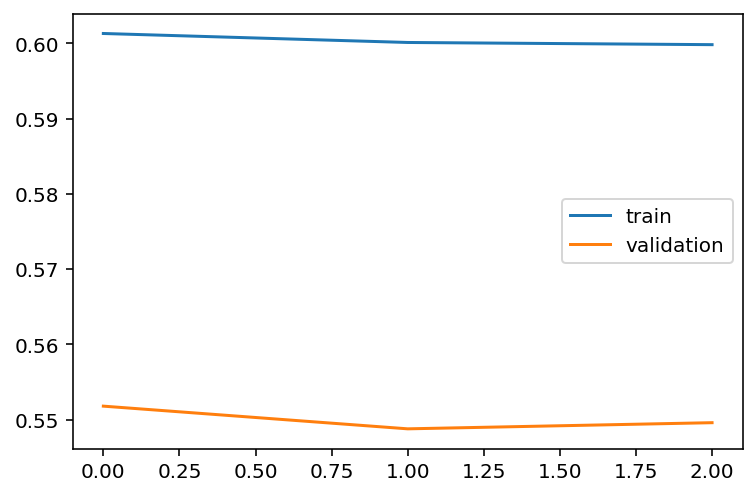

In [315]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


In [316]:
y_pred = model.predict(X_test)

In [317]:
y_train_inv = mag_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = mag_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = mag_transformer.inverse_transform(y_pred)





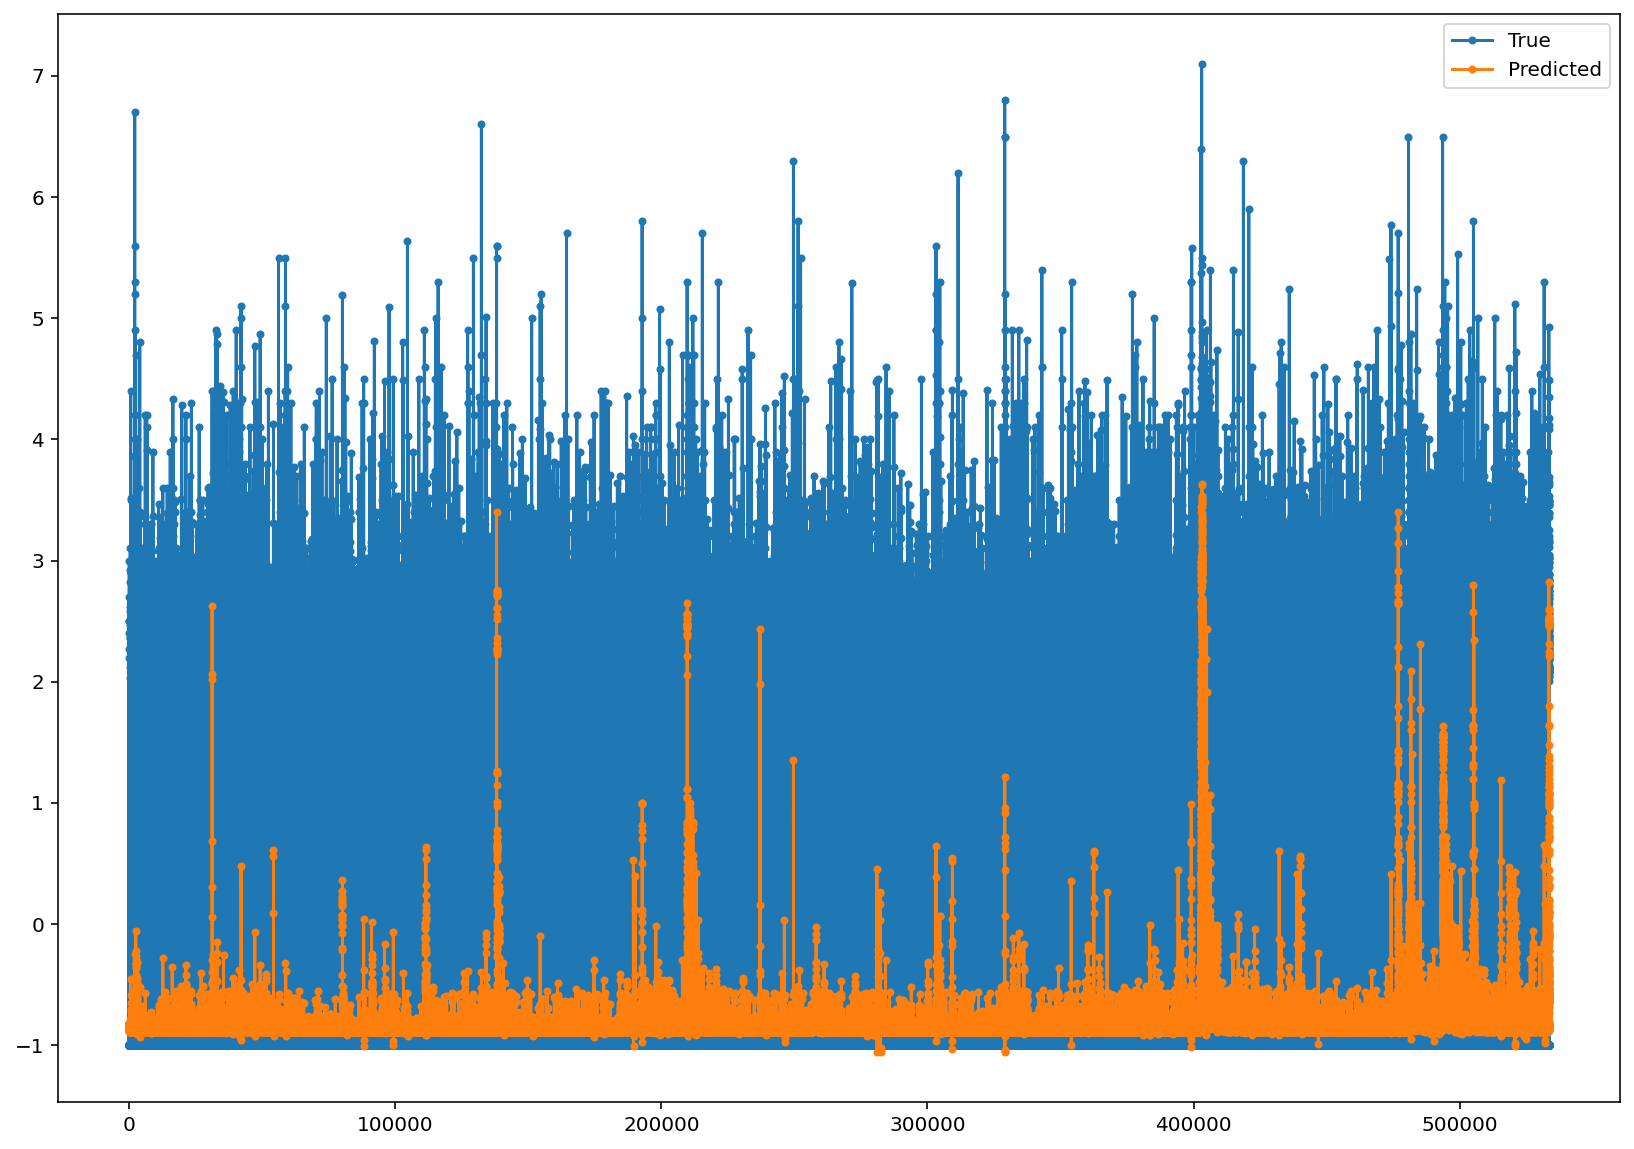

In [318]:
plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")

plt.legend()

### No, no, no, not good, maybe the missing values during resampling impacted the analysis, although I masked them in my LSTM model

In [2]:
print("Hello World!")

Hello World!
